##### Author: Nisha Sundaram

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

In [67]:
# Reading the data
cars_new = pd.read_csv('cars_dataset_cleaned.csv', sep= ";", index_col=None, header=0, engine ='python')

# numerical columns shape
cars_new.select_dtypes(exclude=['object']).shape

# categorical columns shape
cars_new.select_dtypes(include=['object']).shape


(16217, 12)

### Splitting data into Train and Test set

In [68]:
X = cars_new.drop(columns=['price','first_reg','brand','model','model_details','fuel_eff','num_doors'],axis=1)
y = cars_new['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.head()

,car_brand,body_type,condition,num_seats,mileage,power_kW,transmission,displacement,fuel,color,seller,year_built,num_owners,co2_emission_gpkm,fuel_eff_combi_lpkm,fuel_eff_city_lpkm,fuel_eff_highway_lpkm
16103,mercedes-benz,Kombi,Annual_cars,5,19540,190,Automatic,1991.0,Super95,Grey,Retailer,2021,1,165,7,9,6
13652,bmw,SUV,Annual_cars,5,15473,250,Automatic,2993.0,Diesel_PF,Black,Retailer,2021,1,148,5,6,4
6413,ford,Kombi,Used_cars,5,27630,138,Automatic,1999.0,Super95_91,White,Retailer,2021,1,99,4,4,4
10730,bmw,SUV,Demonstration_cars,5,11516,210,Automatic,2993.0,Diesel_PF,Grey,Retailer,2021,1,147,5,6,5
13589,volkswagen,Van,One_day_registered_cars,7,100,150,Automatic,1968.0,Diesel_PF,Black,Retailer,2022,1,178,6,7,6


#### Creating a function that not only plots the errors, it also returns the dictionary with all the performance metrics:

In [69]:
def plot_predictions(y_true, y_pred): 
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=y_pred, y=y_true)
    max_prediction = int(max(y_pred))
    plt.plot(range(max_prediction), range(max_prediction), color="red")
    plt.ylabel('Actual_Values')
    plt.xlabel('Predictions')
    plt.show()

    return {
        'MSE': mean_squared_error(y_true, y_pred), 
        'RMSE': mean_squared_error(y_true, y_pred)**0.5,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_abs_perc_error(y_true, y_pred)
     }


def mean_abs_perc_error(y_true, y_pred):
    results = pd.DataFrame({
        'predictions':y_pred,
        'true_values':y_true
    })
    mape_pre = (results
               .assign(diff = lambda x: abs(x.true_values - x.predictions)/x.true_values)
               .agg({'diff':{'sum','count'}}))
    mape = mape_pre.loc['sum'] / mape_pre.loc['count']
    return mape.values[0]


### Data Preprocessing and Creating Pipelines

In [70]:
#Categorical columns to be one hot encoded
cat_cols_onehot = ["car_brand", "body_type", "condition", "transmission", "fuel", "color", "seller"] 

numeric_features = list(X.select_dtypes(exclude=["object"]))
categorical_features = cat_cols_onehot

# creating a numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))
 
# creating a categorical pipeline
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, numeric_features),
        ("cat_pipe", categoric_pipe, categorical_features),
    ]
)

# fitting and transforming the preprocessor
preprocessor.fit(X_train)
preprocessor.transform(X_train)

<12973x70 sparse matrix of type '<class 'numpy.float64'>'
	with 217914 stored elements in Compressed Sparse Row format>

## 1. Modelling using KNN

In [71]:
knn_pipeline = make_pipeline(preprocessor, 
                             StandardScaler(with_mean=False),
                             VarianceThreshold(threshold=0.5),
                             SelectKBest(score_func=f_regression, k=15),
                             KNeighborsRegressor()
                            )
   
    
# choosing the parameters
knn_param_grid = {
    "selectkbest__k": [10, 20, 40],
    "kneighborsregressor__n_neighbors": range(3, 21, 3),
    "kneighborsregressor__weights": ["uniform", "distance"]
}

knn_search = GridSearchCV(knn_pipeline,
                      knn_param_grid,
                      cv=5,
                      verbose=2)

knn_search.fit(X_train, y_train)

knn_search.predict(X_train)
knn_search.best_params_
knn_search.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=10; total time=   0.9s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=10; total time=   0.9s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=10; total time=   0.9s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=10; total time=   1.0s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=10; total time=   1.0s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=20; total time=   1.0s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkbest__k=20; total time=   0.9s
[CV] END kneighborsregressor__n_neighbors=3, kneighborsregressor__weights=uniform, selectkb

0.9192395660777135

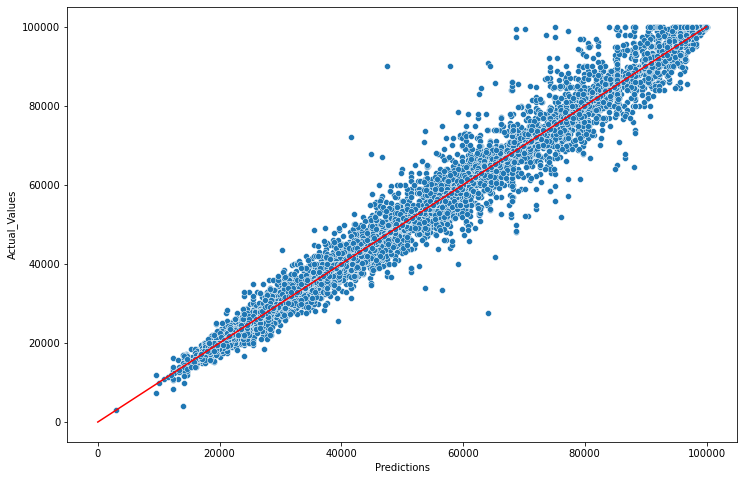

{'MSE': 9913552.90361852,
 'RMSE': 3148.5795056848287,
 'MAE': 1675.5406449152651,
 'MAPE': 0.03659354308360467}

In [72]:
# plotting the true values vs predicted values

results_knn = pd.DataFrame({
    'predictions':knn_search.predict(X_train),
    'true_values':y_train
})
results_knn.head()

plot_predictions(results_knn.true_values, results_knn.predictions)

In [73]:
r2_score(y_train, knn_search.predict(X_train))

0.9814011648818396

In [74]:
knn_search.predict(X_test)

array([46600.        , 38568.61069231, 40747.85714286, ...,
       78792.32692305, 29467.61299142, 29348.61032487])

In [17]:
X_test.head()

,car_brand,body_type,condition,num_seats,mileage,power_kW,transmission,displacement,fuel,color,seller,year_built,num_owners,co2_emission_gpkm,fuel_eff_combi_lpkm,fuel_eff_city_lpkm,fuel_eff_highway_lpkm
9056,ford,Van,Used_cars,7,22580,140,Automatic,1998.0,Diesel_PF,Grey,Retailer,2021,1,149,5,6,5
5232,mercedes-benz,Limousine,Demonstration_cars,5,8000,120,Automatic,1332.0,Super95_91_PF,White,Retailer,2021,1,147,6,9,5
8674,opel,SUV,Demonstration_cars,5,19500,221,Automatic,1598.0,Super95_91,Blue,Retailer,2021,1,34,1,0,0
8172,mercedes-benz,Kombi,Demonstration_cars,5,25926,155,Automatic,1991.0,Super95_91_PF,Grey,Retailer,2021,1,44,1,1,1
10312,volkswagen,Kombi,Annual_cars,5,23990,147,Automatic,2000.0,Diesel_PF,Black,Retailer,2021,2,129,4,6,4


## 2.  Modelling using DecisionTree

In [48]:
dtree_pipe = make_pipeline(
    preprocessor,
    StandardScaler(with_mean=False),
    VarianceThreshold(threshold=0.5), # Features with a training-set variance lower than this threshold will be removed.
    SelectKBest(score_func=f_regression, k=20),  # 'SelectKBest(score_func=f_regression, k=20)' f_classif for regression
    DecisionTreeRegressor()
)

#choosing the parameters
pipe_params_dtree = {
    'decisiontreeregressor__max_depth': [5, 10, 20],
    'decisiontreeregressor__min_samples_split': [2, 4, 6],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 5]
}

dtree_search = GridSearchCV(dtree_pipe, pipe_params_dtree, cv = 10)

dtree_search.fit(X_train, y_train)

dtree_search.best_params_

{'decisiontreeregressor__max_depth': 20,
 'decisiontreeregressor__min_samples_leaf': 2,
 'decisiontreeregressor__min_samples_split': 6}

In [50]:
dtree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['num_seats', 'mileage',
                                                   'power_kW', 'displacement',
                                                   'year_built', 'num_owners',
                                                   'co2_emission_gpkm',
                                                   'fuel_eff_combi_lpkm',
                                                   'fuel_eff_city_lpkm',
                                                   'fuel_eff_highway_lpkm']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                     

In [51]:
dtree_search.best_score_

0.915017751230389

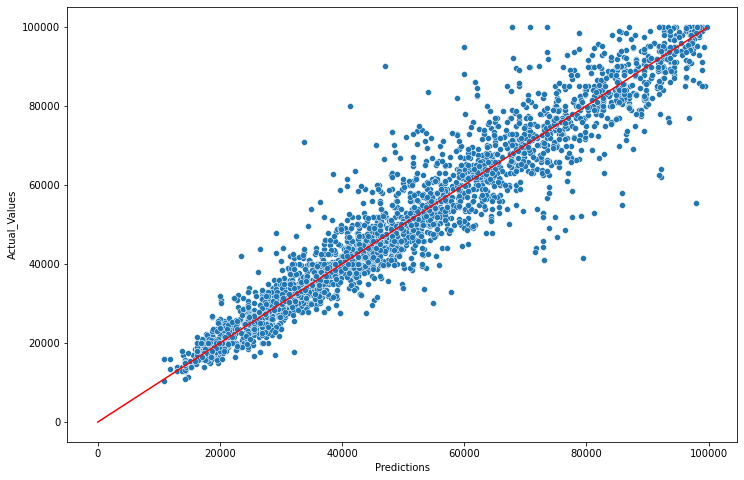

{'MSE': 37819879.045897566,
 'RMSE': 6149.786910608982,
 'MAE': 3966.090730048086,
 'MAPE': 0.08522595146186998}

In [53]:
# plotting the true values vs predicted values

results_dt = pd.DataFrame({
    'predictions':dtree_search.predict(X_test),
    'true_values':y_test
})
results_dt.head()

plot_predictions(results_dt.true_values, results_dt.predictions)

In [54]:
r2_score(y_train, dtree_search.predict(X_train))

0.9677345123727453

## 3. Modelling using Linear Regression

In [55]:
lm_pipeline = make_pipeline(preprocessor, 
                              LinearRegression())

lm_pipeline.fit(X_train, y_train)
lm_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['num_seats', 'mileage',
                                                   'power_kW', 'displacement',
                                                   'year_built', 'num_owners',
                                                   'co2_emission_gpkm',
                                                   'fuel_eff_combi_lpkm',
                                                   'fuel_eff_city_lpkm',
                                                   'fuel_eff_highway_lpkm']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                     

In [56]:
pred = lm_pipeline.predict(X_test)
lm_pipeline.score(X_test,y_test)

0.8446964182525694

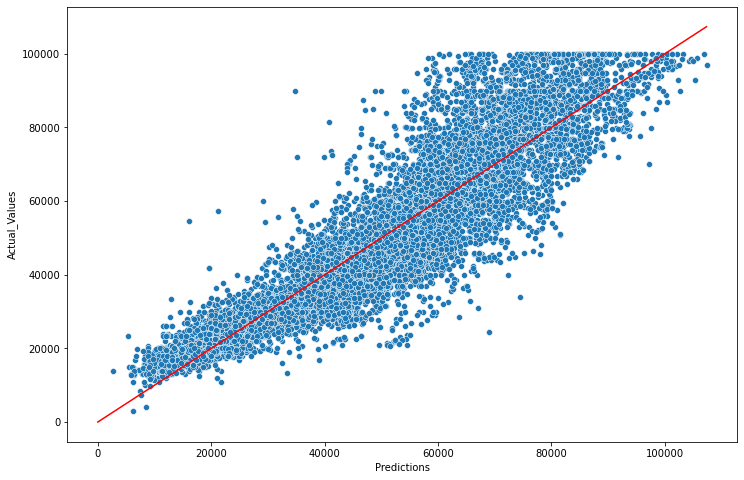

{'MSE': 87405273.86649202,
 'RMSE': 9349.078771006907,
 'MAE': 6926.651553403457,
 'MAPE': 0.15874149593059053}

In [57]:
# plotting the true values vs predicted values

results_lm = pd.DataFrame({
    'predictions':lm_pipeline.predict(X_train),
    'true_values':y_train
})
results_lm.head()

plot_predictions(results_lm.true_values, results_lm.predictions)

In [63]:
r2_score(y_train, lm_pipeline.predict(X_train))

0.8360188024510196

## Comparision of the Results from Different Models

In [60]:
model_selection = {}

model_selection["KNN"] = knn_search.best_score_
model_selection["DecisionTree"] = dtree_search.best_score_
model_selection["LinearRegression"] = lm_pipeline.score(X_test,y_test)

model_selection

{'KNN': 0.9192395660777135,
 'DecisionTree': 0.915017751230389,
 'LinearRegression': 0.8446964182525694}

### Comparision of MAE and RMSE of different models

##### Here we can compare the performance of all the models using the metrics calculated. 
##### Let’s see all the models used to predict the used car price together along with the metrics for the ease of comparison.

In [61]:
data = {'MAE':[1675, 3966, 6926],
        'RMSE':[3148, 6149, 9349]}
        
model = ['KNN', 'DecisionTree','LinearRegression']

 
# Creating pandas DataFrame.
df = pd.DataFrame(data, index = model)
df.index.name='MODELS'
 
# printing the dataframe
df

,MAE,RMSE
MODELS,,
KNN,1675,3148
DecisionTree,3966,6149
LinearRegression,6926,9349


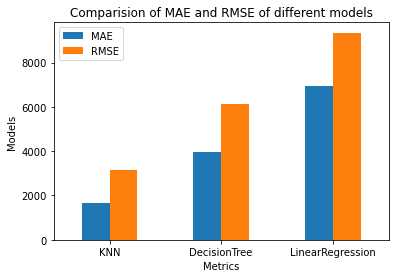

In [62]:
ax = df.plot.bar(rot=0)
plt.title('Comparision of MAE and RMSE of different models')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

### Comparision of R2_SCORES of different models

In [64]:
data = {'Model':['KNN', 'DecisionTree','LinearRegression'],
        'R2_in_%':[98, 97, 83]}

# Creating pandas DataFrame.
df = pd.DataFrame(data)
#df1.index.name='MODELS'
 
# printing the dataframe
df

,Model,R2_in_%
0,KNN,98
1,DecisionTree,97
2,LinearRegression,83


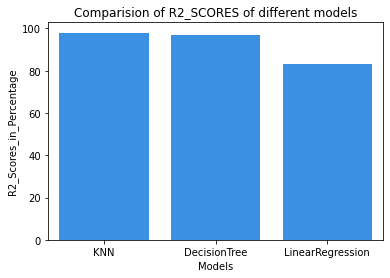

In [65]:
#ax = df1.plot.bar(rot=0)
sns.barplot(data=df, x='Model', y='R2_in_%', color='dodgerblue')
plt.title('Comparision of R2_SCORES of different models')
plt.xlabel('Models')
plt.ylabel('R2_Scores_in_Percentage')
plt.show()

## Conclusion

#### From the table above, it is clear that the best performing model is KNN with the highest R2 Score square (Coefficient of Determination) and least MAE. 

### Saving the Machine Learning Model

#### Here, i am choosing the KNN model.

In [75]:
import pickle

pickle.dump(knn_search, 
            open(file='models/knn_search.sav', 
                 mode='wb'))

In [36]:
pickle.dump(lm_pipeline, 
            open(file='models/lm_pipeline.sav', 
                 mode='wb'))

In [37]:
pickle.dump(dtree_search, 
            open(file='models/dtree_search.sav', 
                 mode='wb'))

In [38]:
X_test.to_csv('test_data/test_data_X_test.csv', sep= ";", index=False)
y_test.to_csv('test_data/test_data_y_test.csv', sep= ";", index=False)

In [39]:
X_test.iloc[0].car_brand

'ford'

In [40]:
# to find the current directory path

import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)

My current directory is : C:\Users\Nisha\Code\Final_project
